In [1]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np

Using TensorFlow backend.


In [2]:
img_shape = (32, 32, 3, 1)
batch_size = 16
latent_dim = 2 # Dimensionality of the latent space: a 2D plane
input_img = keras.Input(shape=img_shape)
x = layers.Conv3D(32, 3, padding='same', activation='relu')(input_img)
x = layers.Conv3D(64, 3, padding='same', activation='relu', strides=(2, 2, 1))(x)
x = layers.Conv3D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv3D(64, 3, padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

# The input image ends up being encoded into these two parameters
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
# Latent-space-sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

In [0]:
decoder_input = layers.Input(K.int_shape(z)[1:]) # Input where you’ll feed z

x = layers.Dense(np.prod(shape_before_flattening[1:]), 
                 activation='relu')(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv3DTranspose(32, 3,padding='same',
                           activation='relu',strides=(2, 2, 1))(x)
x = layers.Conv3D(1, 3,padding='same',activation='sigmoid')(x)
decoder = Model(decoder_input, x)
z_decoded = decoder(z)

In [0]:
class CustomVariationalLayer(keras.layers.Layer):
    
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)
    
    #You implement custom layers You don't use by writing a call method.
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x # You don't use this output, but the layer must return something.
    
y = CustomVariationalLayer()([input_img, z_decoded])

In [6]:
#from keras.datasets import mnist
from keras.datasets import cifar10

vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

#(x_train, _), (x_test, y_test) = mnist.load_data()
# 32x32 images
(x_train, _), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

vae.fit(x=x_train, y=None, shuffle=True, epochs=10, 
        batch_size=batch_size, validation_data=(x_test, None))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3, 1) 0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 32, 32, 3, 32 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv3d_2 (Conv3D)               (None, 16, 16, 3, 64 55360       conv3d_1[0][0]                   
__________________________________________________________________________________________________
conv3d_3 (Conv3D)               (None, 16, 16, 3, 64 110656      conv3d_2[0][0]                   
__________________________________________________________________________________________________
conv3d_4 (

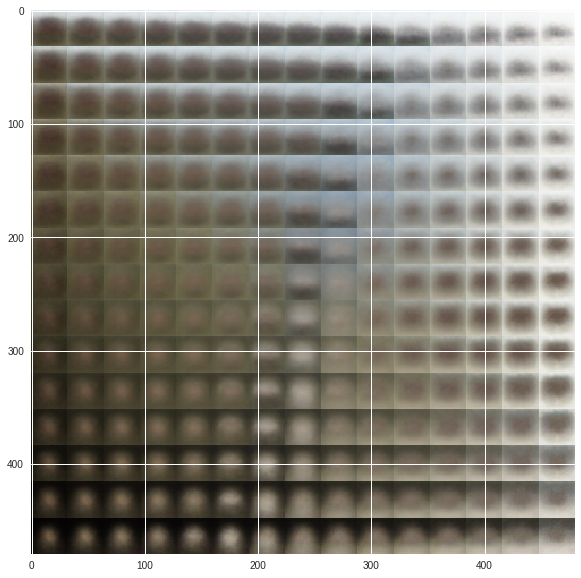

In [15]:
import matplotlib.pyplot as plt
from scipy.stats import norm
n = 15
digit_size = 32
dim = 3
figure = np.zeros((digit_size * n, digit_size * n, dim))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size, dim)
        figure[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit
        
fig = plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()
fig.savefig('VAE_vis.png')